<a href="https://www.kaggle.com/code/tamaturgo/an-lise-pa-ses-clusteriza-o-top-especiais-i?scriptVersionId=132309684" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [61]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans,DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth, Birch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples


# Carregando a base de dados

## Visão Geral do Dataset

O conjunto de dados contém informações sobre diferentes países, como sua população, área geográfica, indicadores econômicos, indicadores de saúde, dentre outros. Cada país é representado por uma observação no conjunto de dados e possui várias características associadas a ele.

In [62]:
df = pd.read_csv("/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv")
df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840


In [63]:
labels = df['country']
df = df.drop("country", axis = 1)
df

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


## Coorelação entre os dados

A correlação é uma medida estatística que nos ajuda a entender a relação entre duas variáveis. Ao calcular a correlação entre diferentes pares de características no conjunto de dados, podemos identificar se elas possuem uma relação positiva (quando aumentam juntas), uma relação negativa (quando uma aumenta e a outra diminui) ou se não há uma relação aparente.

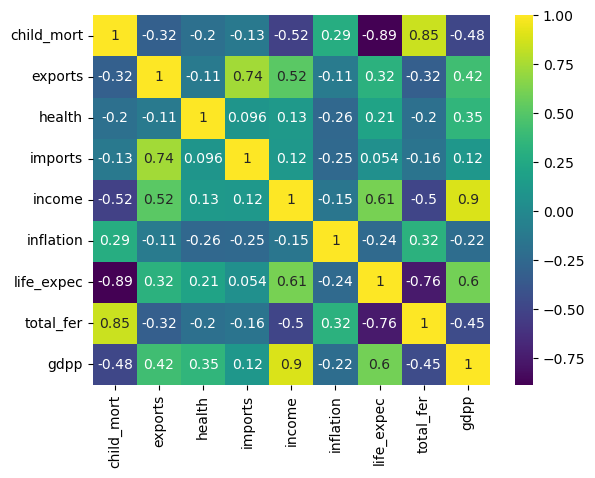

In [64]:
# Calculando a matriz de correlação
correlation_matrix = df.corr(method='pearson')
correlation_matrix = correlation_matrix
# Plotando a matriz de correlação usando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="viridis")
# Exibindo o gráfico
plt.show()

## Processo de Simplificação com Média Harmônica

Para simplificar o conjunto de dados, podemos considerar as características que possuem uma forte relação entre si e combiná-las em uma única feature. Isso reduz a redundância nos dados e permite representar a informação de forma mais compacta.

Além disso, quando duas características são inversamente proporcionais (quando uma aumenta e a outra diminui), podemos aplicar a média harmônica para combiná-las. A média harmônica é uma medida estatística que dá mais peso ao valor menor entre as características, resultando em um valor combinado que reflete sua relação inversa.


In [65]:
# Group 1
pib_p = df["gdpp"]
income = df["income"]
# Group 2
child_m = df["child_mort"]
life_e = df["life_expec"]
total_fer = df["total_fer"]
# Group 3
imports = df["imports"]
exports = df["exports"]

In [66]:
# Unificando PIB per capita + Renda líquida per capita
pib_sum_income = []
for i in range(len(pib_p)):
    n = pib_p.iloc[i] + income.iloc[i]
    pib_sum_income.append(n)

df['income_gdpp'] = pib_sum_income
df = df.drop(['income','gdpp'], axis=1)


In [67]:
# Unificando Importações + Exportações
imports_exports = []
for i in range(len(pib_p)):
    n = imports.iloc[i] + exports.iloc[i]
    imports_exports.append(n)

df['imp_exp'] = imports_exports
df = df.drop(['imports','exports'], axis=1)


In [68]:
# Unificando (Child_mort + total_fer) , Life_expec (Média Harmônica - Inversamente proporcional)
child_m_and_life_e = []
for i in range(len(pib_p)):
    harmonic_avg = 2 / ((1 / (child_m.iloc[i] + total_fer.iloc[i])) + (1 / life_e.iloc[i]))  
    child_m_and_life_e.append(harmonic_avg)

df['child_m_life_e_fer'] = child_m_and_life_e
df = df.drop(['child_mort','life_expec', 'total_fer'], axis=1)


## Revisualizando a matrix de coorelação

Ao revisualizar a matriz de correlação, podemos adotar uma abordagem visual para analisar as relações entre as características e identificar quais são as mais fortemente correlacionadas. Isso nos ajuda a entender a dependência linear entre as variáveis e pode ser útil para selecionar as melhores features para análise posterior ou modelagem.

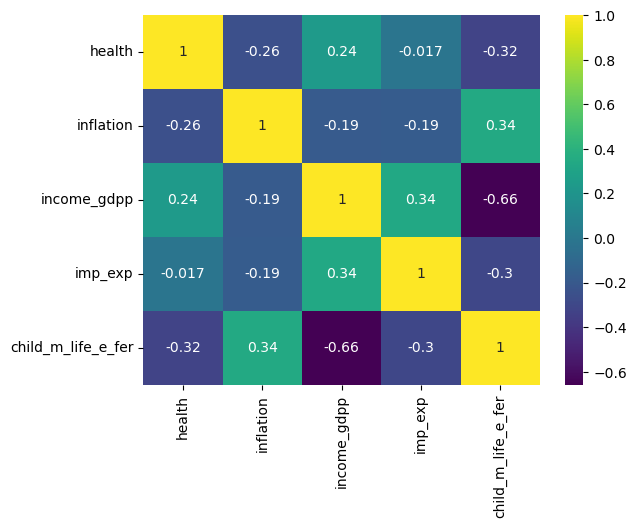

In [69]:
# Calculando a matriz de correlação
correlation_matrix = df.corr(method='pearson')
correlation_matrix = correlation_matrix
# Plotando a matriz de correlação usando seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="viridis")
# Exibindo o gráfico
plt.show()


## Normalização usando MinMaxScaler

A normalização é uma técnica importante para processar dados antes de aplicar algoritmos de aprendizado de máquina. Ela visa transformar as características em uma escala comum, geralmente entre 0 e 1, para evitar a influência desproporcional de diferentes escalas nas análises.

Uma abordagem comum para normalização é o uso do MinMaxScaler, que redimensiona os valores das características para o intervalo desejado. Esse processo preserva a forma geral da distribuição dos dados, garantindo que todas as características tenham a mesma importância durante a análise.

In [70]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()


,health,inflation,income_gdpp,imp_exp,child_m_life_e_fer
0,0.358608,0.126144,0.006232,0.146392,0.827292
1,0.294593,0.080399,0.066802,0.204441,0.286135
2,0.146675,0.187691,0.083864,0.186250,0.466833
3,0.064636,0.245911,0.043355,0.280947,0.961832
4,0.262275,0.052213,0.155075,0.278807,0.180927


# Clusterização

Clusterização é uma técnica de aprendizado não supervisionado que visa agrupar objetos ou exemplos de um conjunto de dados em grupos homogêneos, chamados de clusters. O objetivo é encontrar estruturas intrínsecas nos dados, onde objetos semelhantes são atribuídos ao mesmo grupo, enquanto objetos diferentes são atribuídos a grupos diferentes.

## K-Means com Múltiplos K utilizando a Técnica de Análise com Silhouette Coefficient

O algoritmo K-Means é uma técnica popular de clusterização que visa agrupar objetos em k clusters, onde k é um número pré-definido. Ele é amplamente utilizado devido à sua simplicidade e eficiência computacional.

Uma abordagem comum para determinar o número ideal de clusters no K-Means é realizar uma análise com o coeficiente de silhueta (silhouette coefficient). O coeficiente de silhueta é uma métrica que mede a qualidade de um agrupamento, considerando tanto a similaridade dos objetos dentro do cluster quanto a dissimilaridade em relação aos objetos de outros clusters.

For n_clusters = 2 The average silhouette_score is : 0.42573117873527094
For n_clusters = 3 The average silhouette_score is : 0.3656637344521395
For n_clusters = 4 The average silhouette_score is : 0.37275122062587096


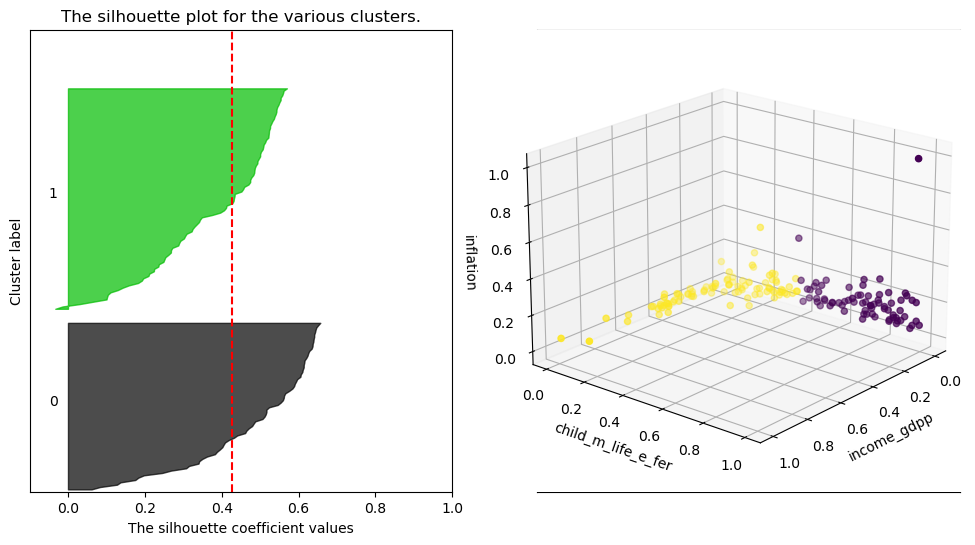

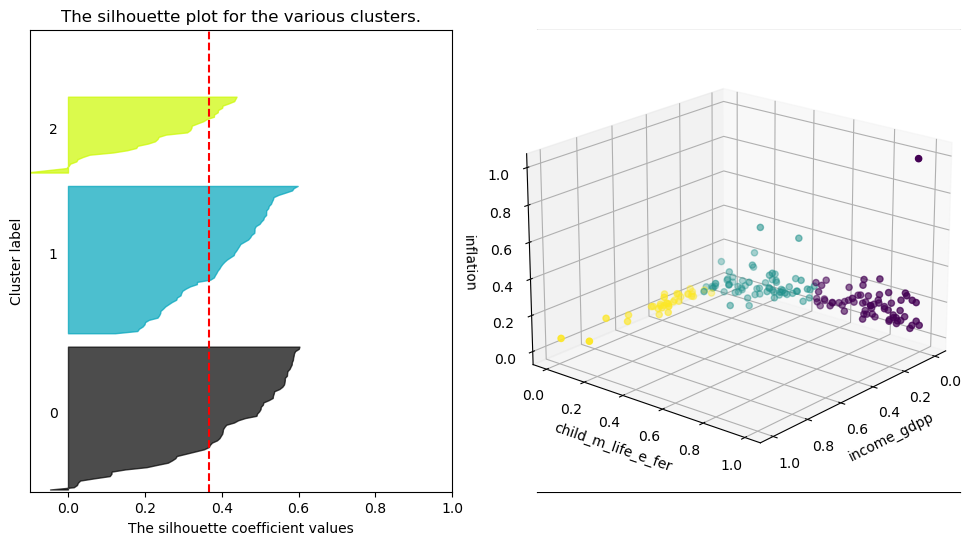

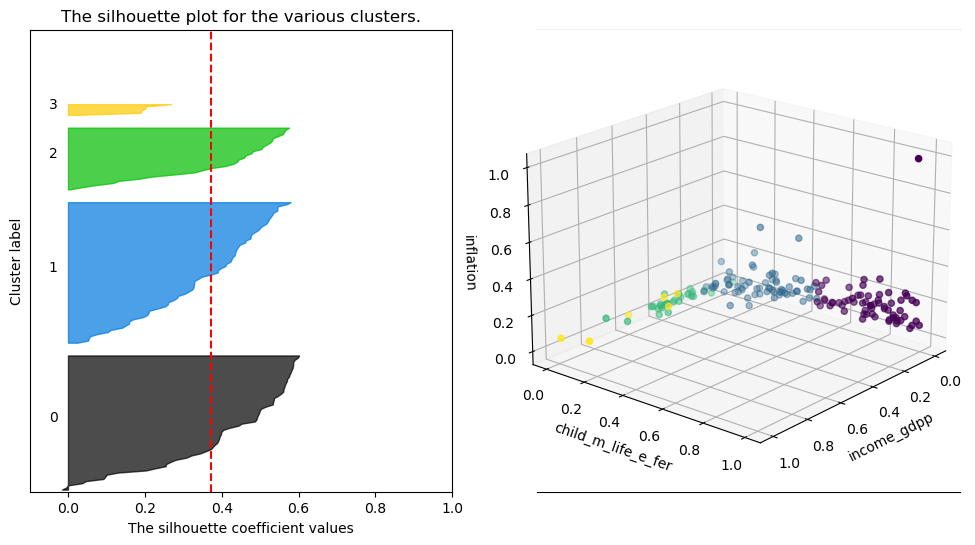

In [71]:
r_clusters = [2, 3, 4]
for nclusters in r_clusters:
     # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)
    
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df) + (nclusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=nclusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(
        "For n_clusters =",
        nclusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(df, cluster_labels)


    y_lower = 1
    for i in range(nclusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nclusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label") 
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    ax2 = fig.add_subplot(111, projection='3d')
    # Definir as coordenadas x, y, z
    x = df['income_gdpp']
    y = df['child_m_life_e_fer']
    z = df['inflation']
    
    # Plotar os pontos 3D com cores diferentes para cada cluster
    scatter = ax2.scatter(x, y, z, c=cluster_labels, cmap='viridis')
    
    # Rotacionar o gráfico 3D
    ax2.view_init(elev=20, azim=40)

    # Definir rótulos dos eixos
    ax2.set_xlabel('income_gdpp')
    ax2.set_ylabel('child_m_life_e_fer')
    ax2.set_zlabel('inflation')
    box = ax2.get_position()
    box.x1 += 0.40
    ax2.set_position(box)
    
    
    

# Clustering with k=2 (Silhouette Coefficient: 0.426)

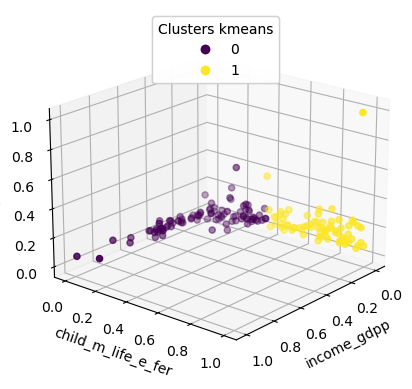

In [72]:
# Definir o número de clusters desejado
n_clusters = 2

# Inicializar o modelo de clusterização (k-means)
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')

# Realizar a clusterização
kmeans.fit(df)

# Definir as coordenadas x, y, z
x = df['income_gdpp']
y = df['child_m_life_e_fer']
z = df['inflation']

# Definir os rótulos dos clusters
clusters = kmeans.labels_

# Criar a figura e o objeto de eixos 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotar os pontos 3D com cores diferentes para cada cluster
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis')

# Adicionar legenda
legend1 = ax.legend(*scatter.legend_elements(), title='Clusters kmeans', loc=9)
ax.add_artist(legend1)

# Rotacionar o gráfico 3D
ax.view_init(elev=20, azim=40)

# Definir rótulos dos eixos
ax.set_xlabel('income_gdpp')
ax.set_ylabel('child_m_life_e_fer')
ax.set_zlabel('inflation')

# Exibir o plot 3D
plt.show()

In [73]:
an_kmeans = [] 
for i in range(n_clusters):
        for j in range(len(labels)):
            if clusters[j] == i:
                an_kmeans.append({"Country": labels[j], "Cluster": clusters[j]})
                
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, clusters))

Silhouette Coefficient: 0.426


## Análise K-Means (k=2)




**A lista de países gerada abaixo apresenta índices ruins em termos de renda per capita, mortalidade infantil e inflação. Esses resultados podem ser atribuídos a uma combinação de fatores, como fragilidade econômica, desigualdade de renda, sistemas de saúde precários e pressões inflacionárias. Esses desafios socioeconômicos dificultam o desenvolvimento sustentável desses países e afetam negativamente a qualidade de vida de suas populações.**

In [90]:
for i in range(len(an_kmeans)):
    if an_kmeans[i]['Cluster'] == 1:
        print(an_kmeans[i]['Country'], end='; ')

Afghanistan; Algeria; Angola; Azerbaijan; Bangladesh; Benin; Bhutan; Bolivia; Botswana; Burkina Faso; Burundi; Cambodia; Cameroon; Cape Verde; Central African Republic; Chad; Comoros; Congo, Dem. Rep.; Congo, Rep.; Cote d'Ivoire; Dominican Republic; Egypt; Equatorial Guinea; Eritrea; Gabon; Gambia; Ghana; Guatemala; Guinea; Guinea-Bissau; Guyana; Haiti; India; Indonesia; Iraq; Kenya; Kiribati; Kyrgyz Republic; Lao; Lesotho; Liberia; Madagascar; Malawi; Mali; Mauritania; Micronesia, Fed. Sts.; Mongolia; Morocco; Mozambique; Myanmar; Namibia; Nepal; Niger; Nigeria; Pakistan; Philippines; Rwanda; Senegal; Sierra Leone; Solomon Islands; South Africa; Sudan; Tajikistan; Tanzania; Timor-Leste; Togo; Turkmenistan; Uganda; Uzbekistan; Vanuatu; Yemen; Zambia; 

**Os outros países estão acima dos índices estabelecidos em termos de renda per capita, mortalidade infantil e inflação devido a uma série de fatores positivos que contribuem para seu desenvolvimento socioeconômico.**

In [89]:
for i in range(len(an_kmeans)):
    if an_kmeans[i]['Cluster'] == 0:
        print(an_kmeans[i]['Country'], end='; ')

Albania; Antigua and Barbuda; Argentina; Armenia; Australia; Austria; Bahamas; Bahrain; Barbados; Belarus; Belgium; Belize; Bosnia and Herzegovina; Brazil; Brunei; Bulgaria; Canada; Chile; China; Colombia; Costa Rica; Croatia; Cyprus; Czech Republic; Denmark; Ecuador; El Salvador; Estonia; Fiji; Finland; France; Georgia; Germany; Greece; Grenada; Hungary; Iceland; Iran; Ireland; Israel; Italy; Jamaica; Japan; Jordan; Kazakhstan; Kuwait; Latvia; Lebanon; Libya; Lithuania; Luxembourg; Macedonia, FYR; Malaysia; Maldives; Malta; Mauritius; Moldova; Montenegro; Netherlands; New Zealand; Norway; Oman; Panama; Paraguay; Peru; Poland; Portugal; Qatar; Romania; Russia; Samoa; Saudi Arabia; Serbia; Seychelles; Singapore; Slovak Republic; Slovenia; South Korea; Spain; Sri Lanka; St. Vincent and the Grenadines; Suriname; Sweden; Switzerland; Thailand; Tonga; Tunisia; Turkey; Ukraine; United Arab Emirates; United Kingdom; United States; Uruguay; Venezuela; Vietnam; 

## DBSCAN - Density-Based Spatial Clustering of Applications with Noise (Silhouette Coefficient: 0.448)

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clusterização baseado em densidade que agrupa objetos em clusters com base na densidade de pontos próximos. Ele é eficaz na identificação de agrupamentos de forma arbitrária e pode lidar com dados de diferentes formas e tamanhos.

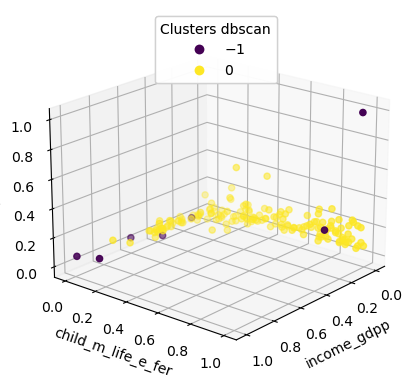

In [76]:
# Inicializar o modelo de clusterização (dbscan)
dbscan = DBSCAN(eps=0.25, min_samples=3)

# Realizar a clusterização
dbscan.fit(df)

# Definir as coordenadas x, y, z
x = df['income_gdpp']
y = df['child_m_life_e_fer']
z = df['inflation']

# Definir os rótulos dos clusters
clusters = dbscan.labels_
# Criar a figura e o objeto de eixos 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotar os pontos 3D com cores diferentes para cada cluster
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis')

# Adicionar legenda
legend1 = ax.legend(*scatter.legend_elements(), title='Clusters dbscan', loc=9)
ax.add_artist(legend1)

# Rotacionar o gráfico 3D
ax.view_init(elev=20, azim=40)

# Definir rótulos dos eixos
ax.set_xlabel('income_gdpp')
ax.set_ylabel('child_m_life_e_fer')
ax.set_zlabel('inflation')
# Exibir o plot 3D
plt.show()

In [77]:
an_dbscan = [] 
n_clusters =  len(np.unique(clusters))
for i in range(-1, n_clusters):
        for j in range(len(labels)):
            if clusters[j] == i:
                an_dbscan.append({"Country": labels[j], "Cluster": clusters[j]})
                
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, clusters))

Silhouette Coefficient: 0.448


## Análise DBSCAN
**A partir dos resultados obtivos através do DBSCAN, é possível notar que há alguns países que não se agrupam com os demais, isso pode acontecer por dois fatores, o país possui economia, qualidade de vida ou inflação acima da média, ou muito abaixo da média. Os países que não se fazem parte da média em relação a Saúde, Economia e qualidade de vida são:**

In [78]:
for i in range(-1, len(an_dbscan)-1):
    if an_dbscan[i]['Cluster'] == -1:
        print(an_dbscan[i]['Country'], end='; ')

Equatorial Guinea; Luxembourg; Malta; Nigeria; Qatar; Singapore; United States; 

**Os demais países a seguir se agrupam pois estão relativamente similares em relação aos parâmetros analisados.**

In [79]:
for i in range(-1, len(an_dbscan)-1):
    if an_dbscan[i]['Cluster'] == 0:
        print(an_dbscan[i]['Country'], end='; ')

Zambia; Afghanistan; Albania; Algeria; Angola; Antigua and Barbuda; Argentina; Armenia; Australia; Austria; Azerbaijan; Bahamas; Bahrain; Bangladesh; Barbados; Belarus; Belgium; Belize; Benin; Bhutan; Bolivia; Bosnia and Herzegovina; Botswana; Brazil; Brunei; Bulgaria; Burkina Faso; Burundi; Cambodia; Cameroon; Canada; Cape Verde; Central African Republic; Chad; Chile; China; Colombia; Comoros; Congo, Dem. Rep.; Congo, Rep.; Costa Rica; Cote d'Ivoire; Croatia; Cyprus; Czech Republic; Denmark; Dominican Republic; Ecuador; Egypt; El Salvador; Eritrea; Estonia; Fiji; Finland; France; Gabon; Gambia; Georgia; Germany; Ghana; Greece; Grenada; Guatemala; Guinea; Guinea-Bissau; Guyana; Haiti; Hungary; Iceland; India; Indonesia; Iran; Iraq; Ireland; Israel; Italy; Jamaica; Japan; Jordan; Kazakhstan; Kenya; Kiribati; Kuwait; Kyrgyz Republic; Lao; Latvia; Lebanon; Lesotho; Liberia; Libya; Lithuania; Macedonia, FYR; Madagascar; Malawi; Malaysia; Maldives; Mali; Mauritania; Mauritius; Micronesia, F

## Affinity Propagation (Silhouette Coefficient: 0.426)

O Affinity Propagation é um algoritmo de clusterização que usa o conceito de propagação de afinidade para encontrar automaticamente o número de clusters e atribuir exemplos a esses clusters. Ele é adequado para conjuntos de dados de tamanho médio a grande e pode ser aplicado em diversos domínios.

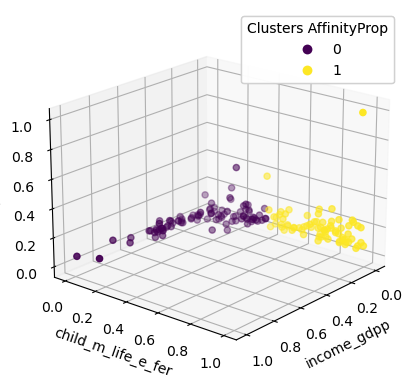

In [80]:
af = AffinityPropagation(preference=-4)
# Realizar a clusterização
af.fit(df)

# Definir as coordenadas x, y, z
x = df['income_gdpp']
y = df['child_m_life_e_fer']
z = df['inflation']

# Definir os rótulos dos clusters
clusters = af.labels_

# Criar a figura e o objeto de eixos 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotar os pontos 3D com cores diferentes para cada cluster
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis')

# Adicionar legenda
legend1 = ax.legend(*scatter.legend_elements(), title='Clusters AffinityProp', loc=0)
ax.add_artist(legend1)

# Rotacionar o gráfico 3D
ax.view_init(elev=20, azim=40)

# Definir rótulos dos eixos
ax.set_xlabel('income_gdpp')
ax.set_ylabel('child_m_life_e_fer')
ax.set_zlabel('inflation')
# Exibir o plot 3D
plt.show()

In [81]:
an_affp = [] 
n_clusters =  len(np.unique(clusters))
for i in range(-1, n_clusters):
        for j in range(len(labels)):
            if clusters[j] == i:
                an_affp.append({"Country": labels[j], "Cluster": clusters[j]})

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, clusters))

Silhouette Coefficient: 0.426


## Análise Affinity Propagation
**A partir dos resultados obtivos através do AffinityPropagation, é possível notar que os grupos formados se assemelham aos grupos formados pelo algoritmo k-means, o grupo dos países com a pior situação econônima e social são:**

In [91]:
for i in range(-1, len(an_affp)-1):
    if an_affp[i]['Cluster'] == 1:
        print(an_affp[i]['Country'], end='; ')

Zambia; Afghanistan; Algeria; Angola; Azerbaijan; Bangladesh; Benin; Bhutan; Bolivia; Botswana; Burkina Faso; Burundi; Cambodia; Cameroon; Cape Verde; Central African Republic; Chad; Comoros; Congo, Dem. Rep.; Congo, Rep.; Cote d'Ivoire; Dominican Republic; Egypt; Equatorial Guinea; Eritrea; Gabon; Gambia; Ghana; Guatemala; Guinea; Guinea-Bissau; Guyana; Haiti; India; Indonesia; Iraq; Kenya; Kiribati; Kyrgyz Republic; Lao; Lesotho; Liberia; Madagascar; Malawi; Mali; Mauritania; Micronesia, Fed. Sts.; Mongolia; Morocco; Mozambique; Myanmar; Namibia; Nepal; Niger; Nigeria; Pakistan; Philippines; Rwanda; Senegal; Sierra Leone; Solomon Islands; South Africa; Sudan; Tajikistan; Tanzania; Timor-Leste; Togo; Turkmenistan; Uganda; Uzbekistan; Vanuatu; Yemen; 

**Os países com melhores indicativos econômicos e sociais são:**

In [83]:
for i in range(-1, len(an_affp)-1):
    if an_affp[i]['Cluster'] == 0:
        print(an_affp[i]['Country'], end='; ')

Albania; Antigua and Barbuda; Argentina; Armenia; Australia; Austria; Bahamas; Bahrain; Barbados; Belarus; Belgium; Belize; Bosnia and Herzegovina; Brazil; Brunei; Bulgaria; Canada; Chile; China; Colombia; Costa Rica; Croatia; Cyprus; Czech Republic; Denmark; Ecuador; El Salvador; Estonia; Fiji; Finland; France; Georgia; Germany; Greece; Grenada; Hungary; Iceland; Iran; Ireland; Israel; Italy; Jamaica; Japan; Jordan; Kazakhstan; Kuwait; Latvia; Lebanon; Libya; Lithuania; Luxembourg; Macedonia, FYR; Malaysia; Maldives; Malta; Mauritius; Moldova; Montenegro; Netherlands; New Zealand; Norway; Oman; Panama; Paraguay; Peru; Poland; Portugal; Qatar; Romania; Russia; Samoa; Saudi Arabia; Serbia; Seychelles; Singapore; Slovak Republic; Slovenia; South Korea; Spain; Sri Lanka; St. Vincent and the Grenadines; Suriname; Sweden; Switzerland; Thailand; Tonga; Tunisia; Turkey; Ukraine; United Arab Emirates; United Kingdom; United States; Uruguay; Venezuela; Vietnam; 

## BIRCH - Balanced Iterative Reducing and Clustering using Hierarchies

O BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) é um algoritmo de clusterização hierárquico que é projetado para lidar com grandes conjuntos de dados. Ele oferece uma abordagem eficiente para agrupar e resumir dados de forma hierárquica, reduzindo a quantidade de memória necessária para o processamento.

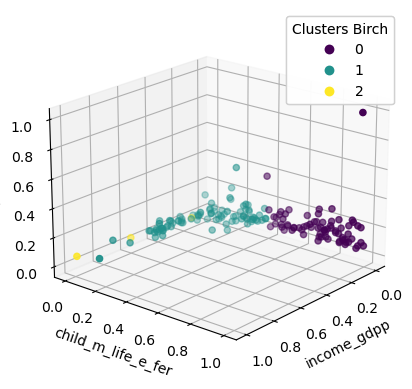

In [84]:
birch = Birch(threshold=0.33, n_clusters=None)
# Realizar a clusterização
birch.fit(df)

# Definir as coordenadas x, y, z
x = df['income_gdpp']
y = df['child_m_life_e_fer']
z = df['inflation']

# Definir os rótulos dos clusters
clusters = birch.labels_

# Criar a figura e o objeto de eixos 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotar os pontos 3D com cores diferentes para cada cluster
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis')

# Adicionar legenda
legend1 = ax.legend(*scatter.legend_elements(), title='Clusters Birch', loc=0)
ax.add_artist(legend1)

# Rotacionar o gráfico 3D
ax.view_init(elev=20, azim=40)

# Definir rótulos dos eixos
ax.set_xlabel('income_gdpp')
ax.set_ylabel('child_m_life_e_fer')
ax.set_zlabel('inflation')
# Exibir o plot 3D
plt.show()

In [85]:
an_birch = [] 
n_clusters =  len(np.unique(clusters))
for i in range(n_clusters):
        for j in range(len(labels)):
            if clusters[j] == i:
                an_birch.append({"Country": labels[j], "Cluster": clusters[j]})
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(df, clusters))

Silhouette Coefficient: 0.420


## Análise Birch
**A partir dos resultados obtivos através do Birch, é possível notar que há alguns países que apenas 3 países se destacam de clusters maiores, isso se dá ao fato que esses países tem uma ótima economia, baixa infração e bons indicativos sociáis, estes países são:**

In [86]:
for i in range(-1, len(an_birch)-1):
    if an_birch[i]['Cluster'] == 2:
        print(an_birch[i]['Country'], end='; ')

Singapore; Luxembourg; Malta; 

**Os países abaixo possuem indicativos sociais dentro da média, alguns podem ter problemas com inflação, mas grande parte possue uma boa economia:**

In [87]:
for i in range(-1, len(an_birch)-1):
    if an_birch[i]['Cluster'] == 1:
        print(an_birch[i]['Country'], end='; ')

Albania; Antigua and Barbuda; Argentina; Armenia; Australia; Austria; Bahamas; Bahrain; Barbados; Belarus; Belgium; Belize; Bosnia and Herzegovina; Brazil; Brunei; Bulgaria; Canada; Chile; China; Colombia; Costa Rica; Croatia; Cyprus; Czech Republic; Denmark; Ecuador; El Salvador; Estonia; Fiji; Finland; France; Georgia; Germany; Greece; Grenada; Hungary; Iceland; Iran; Ireland; Israel; Italy; Jamaica; Japan; Jordan; Kazakhstan; Kuwait; Latvia; Lebanon; Libya; Lithuania; Macedonia, FYR; Malaysia; Maldives; Mauritius; Moldova; Montenegro; Netherlands; New Zealand; Norway; Oman; Panama; Paraguay; Peru; Poland; Portugal; Qatar; Romania; Russia; Samoa; Saudi Arabia; Serbia; Seychelles; Slovak Republic; Slovenia; South Korea; Spain; Sri Lanka; St. Vincent and the Grenadines; Suriname; Sweden; Switzerland; Thailand; Tonga; Tunisia; Turkey; Ukraine; United Arab Emirates; United Kingdom; United States; Uruguay; Venezuela; Vietnam; 

**Os países que fazem parte do grupo abaixo tem os piores indicativos sociais, pior economia, e podem ter problemas com inflação.** 

In [88]:
for i in range(-1, len(an_birch)-1):
    if an_birch[i]['Cluster'] == 0:
        print(an_birch[i]['Country'], end='; ')

Afghanistan; Algeria; Angola; Azerbaijan; Bangladesh; Benin; Bhutan; Bolivia; Botswana; Burkina Faso; Burundi; Cambodia; Cameroon; Cape Verde; Central African Republic; Chad; Comoros; Congo, Dem. Rep.; Congo, Rep.; Cote d'Ivoire; Dominican Republic; Egypt; Equatorial Guinea; Eritrea; Gabon; Gambia; Ghana; Guatemala; Guinea; Guinea-Bissau; Guyana; Haiti; India; Indonesia; Iraq; Kenya; Kiribati; Kyrgyz Republic; Lao; Lesotho; Liberia; Madagascar; Malawi; Mali; Mauritania; Micronesia, Fed. Sts.; Mongolia; Morocco; Mozambique; Myanmar; Namibia; Nepal; Niger; Nigeria; Pakistan; Philippines; Rwanda; Senegal; Sierra Leone; Solomon Islands; South Africa; Sudan; Tajikistan; Tanzania; Timor-Leste; Togo; Turkmenistan; Uganda; Uzbekistan; Vanuatu; Yemen; Zambia; 